# BAYESIAN LINEAR FIT WITH `PyMC`
Here, we are going to showcase the Bayesian approach to performing a simple linear regression, both with arbitrary and with conjugated priors

## Imports

In [1]:
import pymc
import seaborn           as sbn
import matplotlib.pyplot as plt
import numpy             as np

from pymc.Matplot              import plot as mcplot
from IPython.display           import Image
from scipy.stats               import multivariate_normal, invgamma, t
from scipy.special             import gamma
from math                      import pi, sqrt
from numpy.linalg              import inv, det

## Notebook Settings

In [2]:
%matplotlib notebook
sbn.set_style('whitegrid')

## Define Bivariate t-Distribution

In [3]:
class bivariate_t:
    def __init__(self, dof, mean, covm):
        self.__dof  = dof
        self.__mean = mean
        self.__covm = covm
        
    def pdf(self, x):
        return (1/(2 * pi)) * (1 + (1/self.__dof) *
               (x - self.__mean).T.dot(inv(self.__covm)).dot(x - self.__mean))**(-(self.__dof + 2)/2)

## Create Synthetic Data to Fit
Feel free to change the annotated values below!

<IPython.core.display.Javascript object>


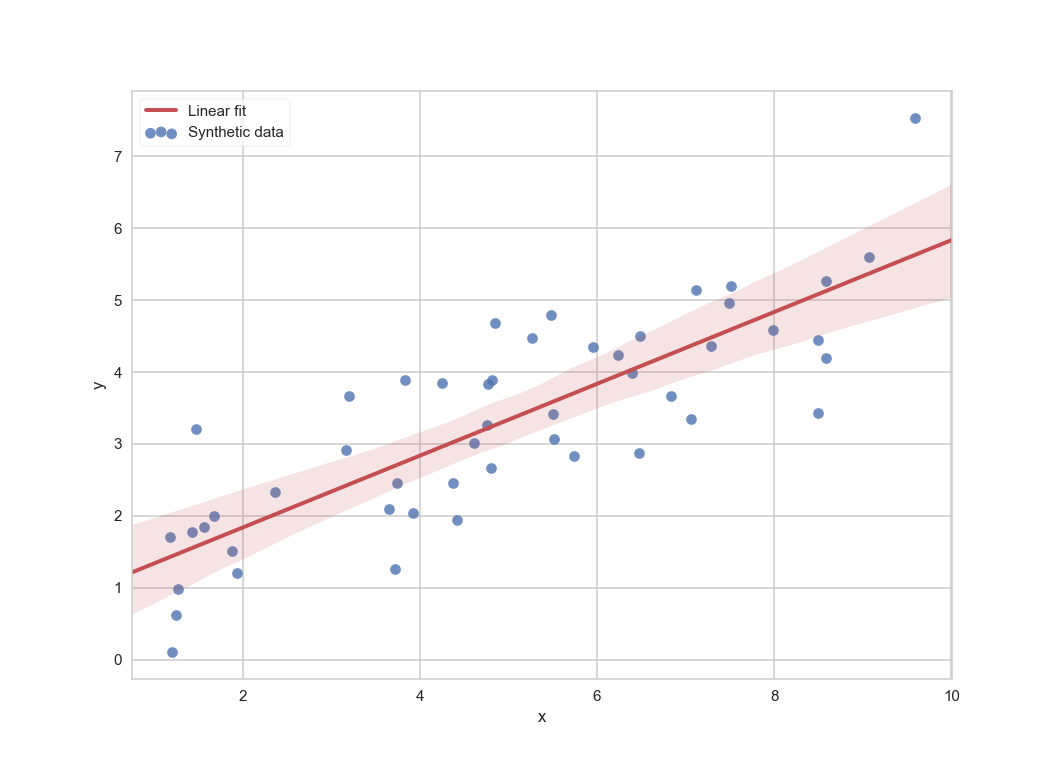

In [4]:
n_draws = 50      # Number of samples
x_lower = 1.0     # Lower bound of x-values
x_upper = 10.0    # Upper bound of x-values

true_slope = 0.5  # The slope used to generate the synthetic data
true_intcp = 1.0  # The intercept used to generate the synthetic data
true_varnc = 0.8  # The variance used to generate the synthetic data

x = pymc.runiform(x_lower, x_upper, n_draws)
e = pymc.rnormal(0, 1/true_varnc, n_draws)
y = true_slope * x + true_intcp + e

fig = plt.figure(num='A Sneak Preview on the Data', figsize=(9.7, 7))
ax = sbn.regplot(x, y,
                 ci=99,
                 label='Synthetic data',
                 scatter_kws={'alpha': 0.8, 's': 50},
                 line_kws={'color': '#c44e52', 'label': 'Linear fit'})
_ = ax.legend(loc='best', scatterpoints=3, frameon=True, fancybox=True, framealpha=0.7)
_ = ax.set_xlabel('x')
_ = ax.set_ylabel('y')

## With Non-Conjugate Priors
### Define the priors and their hyperparameters
Why not put independent Gaussian priors on slope and intercept as well as a half-Normal on the standard deviation of the error term (it has to be positive)? Feel free to express you belief through the hyperparameters!

In [5]:
slope_mean = 0.0  # Mean value of the slope
slope_std  = 3.0  # Standard deviation of the slope

intcp_mean = 0.0  # Mean value of the intercept
intcp_std  = 3.0  # Standard deviation of the intercept

varnc_std  = 3.0  # Standard deviation of the variance in the (Gaussian) error term

slope = pymc.Normal('slope', slope_mean, 1/slope_std**2)
intcp = pymc.Normal('intcp', intcp_mean, 1/intcp_std**2)
varnc = pymc.HalfNormal('varnc', 1/varnc_std**2)

x_obs = pymc.Uniform('x', x_lower, x_upper, value=x, observed=True)  # Not strictly necessary. Only done to
                                                                     # have x on the graph of the model later.
@pymc.deterministic
def mean(slope=slope, intcp=intcp, x=x_obs):
    return slope*x + intcp

### Define the Likelihood
Our wild guess is that the _y_-values scatter normally around the line defined by slope and intercept.

In [6]:
y_obs = pymc.Normal('y', mean, 1/varnc, value=y, observed=True)

### Set up the model and display its Directed Acyclic Graph (DAG)
Note that the latter works only after some fiddling with the `pydot(plus)` package and adaption of the plotting routine of `pymc`

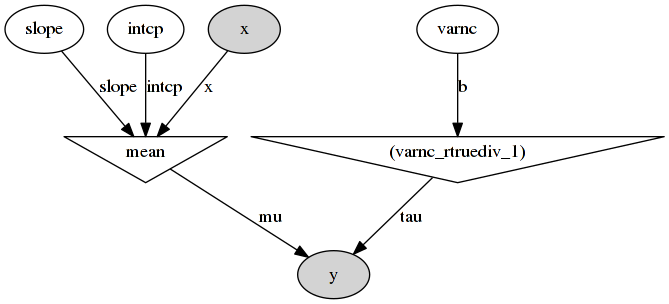

In [7]:
model = pymc.Model([slope, intcp, varnc, x_obs, y_obs])
mcmc  = pymc.MCMC(model)

dag = pymc.graph.dag(model)
Image(dag.create_png())

### Sample the posterior distribution

In [8]:
mcmc.sample(100000, burn=10000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 22.0 sec

### Plot the posterior marginals
Specify your choice of: _'slope'_, _'intcp'_, or _'varnc'_

Plotting varnc


<IPython.core.display.Javascript object>


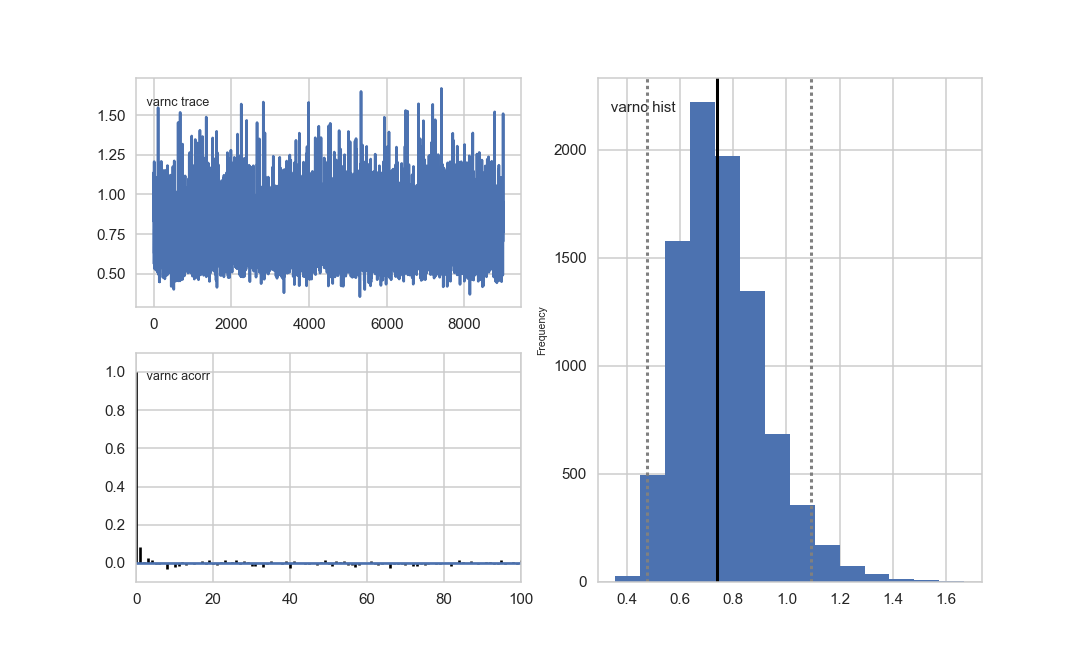

In [9]:
mcplot(mcmc.trace('varnc'))

That does not look too bad. But just examining the posterior marginals might hide some information.
### Posterior correlation
The ground truth is shown in green.

<IPython.core.display.Javascript object>


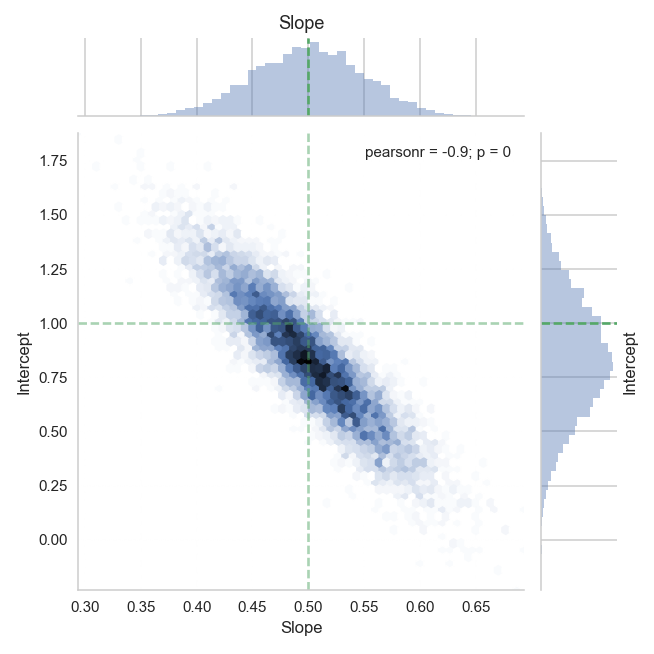

In [10]:
traces = mcmc.trace('slope').gettrace(), mcmc.trace('intcp').gettrace()
axgrid = sbn.jointplot(*traces, kind='hex')
axgrid = axgrid.set_axis_labels(xlabel='Slope', ylabel='Intercept')
x_axis = axgrid.ax_marg_x
y_axis = axgrid.ax_marg_y
j_axis = axgrid.ax_joint
figure = axgrid.fig
x_axis.set_title('Slope')
x_axis.axvline(x=true_slope, linestyle='dashed', color='#55a868')
y_axis.set_ylabel('Intercept')
y_axis.yaxis.set_label_position('right')
y_axis.axhline(y=true_intcp, linestyle='dashed', color='#55a868')
j_axis.axvline(x=true_slope, linestyle='dashed', color='#55a868', alpha=0.5)
j_axis.axhline(y=true_intcp, linestyle='dashed', color='#55a868', alpha=0.5)
figure.tight_layout()

Makes sense. The larger the slope, the smaller the intercept. So maybe, we should not put _independent, univariate_ priors on the two after all, but a _single, bivariate_ prior that reflects this natural correlation. At the very least, we should keep in mind that the errors on slope and intercept are _not_ uncorrelated.

## With Conjugate Priors
If we want the _posterior_ distribution to stay the same as the _prior_ distribution, then we should use priors that are _conjugate_ to the likelihood. In our case, that means a bivariate Gaussian on slope and intercept together (allowing us to specify our belief on their mutual correlation), as well as an Inverse-Gamma distribution on the variance of the error term. Note that this variance also appears in the aforementioned bivariate Gaussian, as the joint prior on slope and intercept _conditionally_ depends on it.
### Set up conjugate priors and define their hyperparameters

In [11]:
corr_prior = -0.5  #  Correlation between slope and intercept

vari_alpha = +1.0  # Alpha-parameter of the Inverse-Gamme prior on the variance in the (Gaussian) error term
vari_beta  = +1.0  #  Beta-parameter of the Inverse-Gamme prior on the variance in the (Gaussian) error term

beta_mean = np.array([intcp_mean, slope_mean])
beta_covm = np.array([[intcp_std**2, corr_prior*intcp_std*slope_std],
                      [corr_prior*intcp_std*slope_std, slope_std**2]])
vari = pymc.InverseGamma('vari', vari_alpha, vari_beta)
beta = pymc.MvNormalCov('beta', beta_mean, vari*beta_covm)

@pymc.deterministic
def mean_cp(beta=beta, x=x_obs):
    return beta[1]*x + beta[0]

### Redefine our likelihood

In [12]:
y_cp = pymc.Normal('y', mean_cp, 1/vari, value=y, observed=True)

### Set up the new model and display its DAG

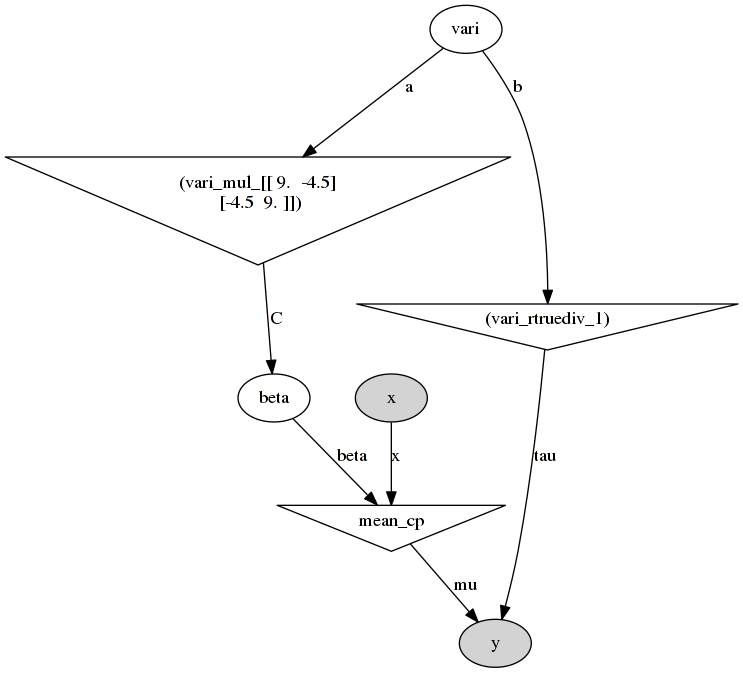

In [14]:
cp_model = pymc.Model([beta, vari, x_obs, y_cp])
cp_mcmc  = pymc.MCMC(cp_model)

cp_dag = pymc.graph.dag(cp_model)
Image(cp_dag.create_png())

### Sample the Normal - Inverse Gamma posterior distribution

In [15]:
cp_mcmc.sample(100000, burn=10000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 24.4 sec

### Plot the posterior marginals of the new model
Enter you choice of: _'beta'_, _'vari'_, or *'y_pred'*

Plotting beta_0


<IPython.core.display.Javascript object>


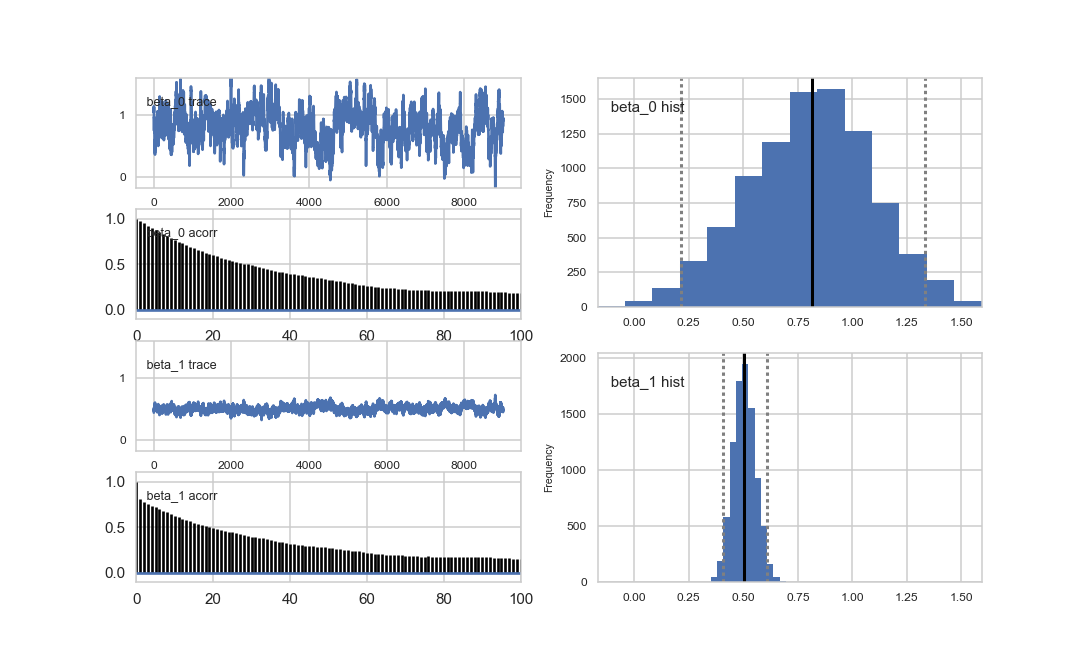

Plotting beta_1


In [16]:
mcplot(cp_mcmc.trace('beta'))

### Posterior distribution of the error-term variance

<IPython.core.display.Javascript object>


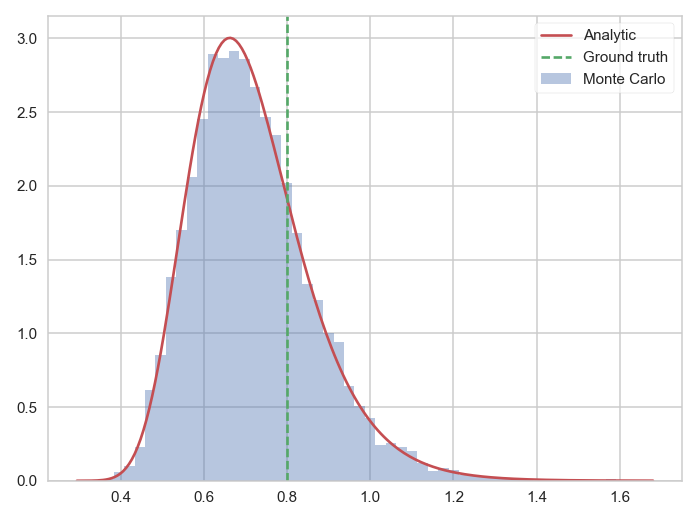

In [17]:
beta_hat = np.flipud(np.polyfit(x, y, 1))
X    = np.array([np.ones_like(x), x]).T
s_sq = (y - X.dot(beta_hat)).T.dot(y - X.dot(beta_hat))
rest = (beta_mean - beta_hat).T.dot(inv(beta_covm + inv(X.T.dot(X)))).dot(beta_mean - beta_hat)
invg = invgamma(n_draws/2 + vari_alpha, 0, vari_beta + s_sq/2 + rest/2)

fig = plt.figure(num='Numeric vs. Analytic: The Posterior of the Variance')
ax  = sbn.distplot(cp_mcmc.trace('vari').gettrace(), kde=False, norm_hist=True, label='Monte Carlo')

x_lims = ax.get_xlim()
x_vals = np.linspace(*x_lims, 200)

ax.plot(x_vals, invg.pdf(x_vals), color='#c44e52', label='Analytic')
ax.axvline(x=true_varnc, linestyle='dashed', color='#55a868', label='Ground truth')
ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.7)
fig.tight_layout()

### Posterior distribution of slope and intercept
First the Monte-Carlo results in blue, the ground truth in green, ...

<IPython.core.display.Javascript object>


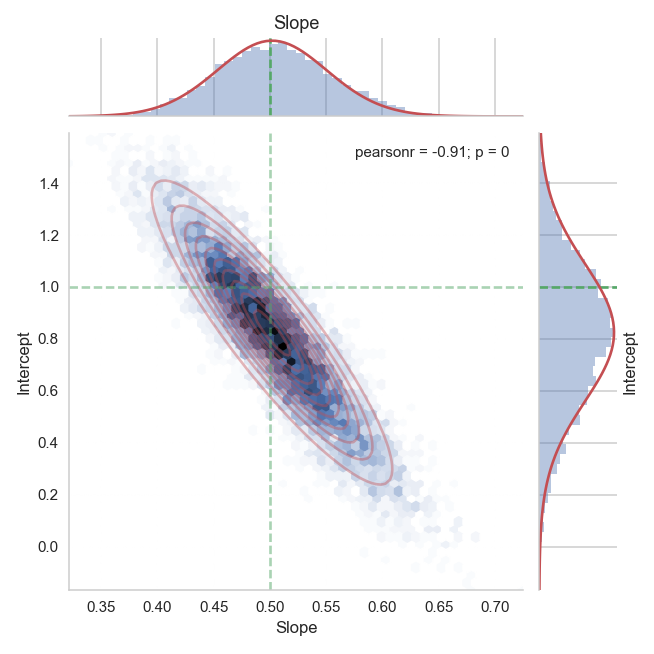

In [18]:
traces = cp_mcmc.trace('beta').gettrace().T[1], cp_mcmc.trace('beta').gettrace().T[0]
axgrid = sbn.jointplot(*traces, kind='hex', marginal_kws={'norm_hist': True})
axgrid = axgrid.set_axis_labels(xlabel='Slope', ylabel='Intercept')
x_axis = axgrid.ax_marg_x
y_axis = axgrid.ax_marg_y
j_axis = axgrid.ax_joint
figure = axgrid.fig
x_axis.set_title('Slope')
x_axis.autoscale(False)
x_axis.axvline(x=true_slope, linestyle='dashed', color='#55a868')
y_axis.set_ylabel('Intercept')
y_axis.yaxis.set_label_position('right')
y_axis.autoscale(False)
y_axis.axhline(y=true_intcp, linestyle='dashed', color='#55a868')
j_axis.axvline(x=true_slope, linestyle='dashed', color='#55a868', alpha=0.5)
j_axis.axhline(y=true_intcp, linestyle='dashed', color='#55a868', alpha=0.5)
figure.tight_layout()

... and then the analytic solution in red.

In [19]:
L     = inv(beta_covm)
mu    = inv(L + X.T.dot(X)).dot(X.T.dot(X).dot(beta_hat) + L.dot(beta_mean))
dof   = n_draws + 2*vari_alpha
sigma = ((2*vari_beta + s_sq + rest)/(n_draws + 2*vari_alpha)) * inv(L + X.T.dot(X))

bivart = bivariate_t(dof, mu, sigma)
x_marg = t(dof, mu[1], sqrt(sigma[1, 1]))
y_marg = t(dof, mu[0], sqrt(sigma[0, 0]))

x_vals, y_vals = np.meshgrid(np.linspace(*j_axis.get_xlim(), 100),
                             np.linspace(*j_axis.get_ylim(), 100))
grid = np.empty(x_vals.shape + (2,))
grid[:, :, 0] = y_vals
grid[:, :, 1] = x_vals

z_vals = np.apply_along_axis(bivart.pdf, 2, grid)
_ = j_axis.contour(x_vals, y_vals, z_vals, 10, colors='#c44e52', alpha=0.4)
_ = y_axis.plot(y_marg.pdf(y_vals.T[0]), y_vals.T[0], color='#c44e52')
_ = x_axis.plot(x_vals[0], x_marg.pdf(x_vals[0]), color='#c44e52')

### Posterior predictive distribution of $y$ for a new observation of $x$

<IPython.core.display.Javascript object>


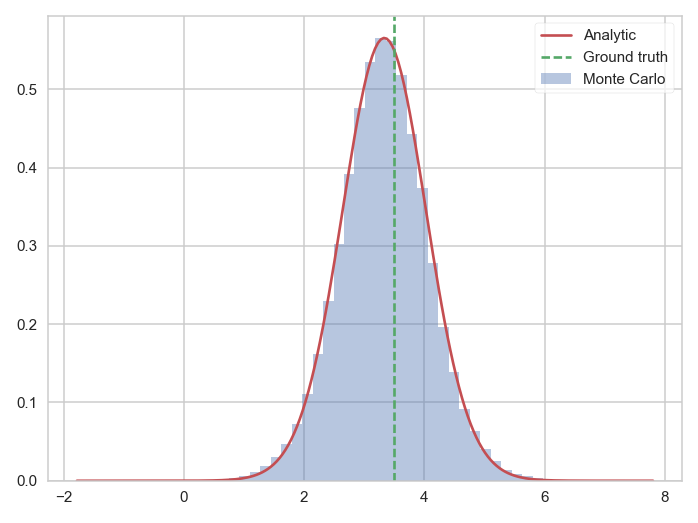

In [23]:
x_pred = 5.  # Enter desired x-value here

X_pred = np.array([1., x_pred])
a_post = n_draws/2 + vari_alpha
b_post = vari_beta + s_sq/2 + rest/2
s_post = inv(L + X.T.dot(X))
y_dist = t(2*a_post, X_pred.dot(mu), (b_post/a_post)*(1 + X_pred.dot(s_post).dot(X_pred)))

beta_trace = cp_mcmc.trace('beta').gettrace().T
vari_trace = cp_mcmc.trace('vari').gettrace()
trace_size = vari_trace.size
post_ypred = np.random.normal(X_pred.dot(beta_trace), vari_trace, (10, trace_size)).flatten()

fig = plt.figure(num='Numeric vs. Analytic: The Posterior Predictive')
ax  = sbn.distplot(post_ypred, kde=False, norm_hist=True, label='Monte Carlo')

y_lims = ax.get_xlim()
y_vals = np.linspace(*y_lims, 200)
_ = ax.plot(y_vals, y_dist.pdf(y_vals), color='#c44e52', label='Analytic')
ax.axvline(true_slope*x_pred + true_intcp, linestyle='dashed', color='#55a868', label='Ground truth')
_ = ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.7)
fig.tight_layout()